In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import src.features.build_features as FeaturesManager

In [4]:
seasons_year = [2015, 2016, 2017, 2018]
features_data = FeaturesManager.build_features(seasons_year)
features_data.sample(10)

  0%|          | 0/1230 [00:00<?, ?it/s]

  0%|          | 0/1229 [00:00<?, ?it/s]

In [5]:
distance_data = features_data[['Shot distance', 'Is Goal']].dropna()
X = distance_data['Shot distance'].to_numpy().reshape(-1, 1)
y = distance_data['Is Goal'].to_numpy().reshape(-1, 1)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [8]:
accuracy = clf.score(X_valid, y_valid)
print(f'Accuracy on validation set = {np.around(100.*accuracy, 2)}%')

Accuracy on validation set = 90.67%


0.9066831583334454
Dumb Accuracy on validation set = 90.67%


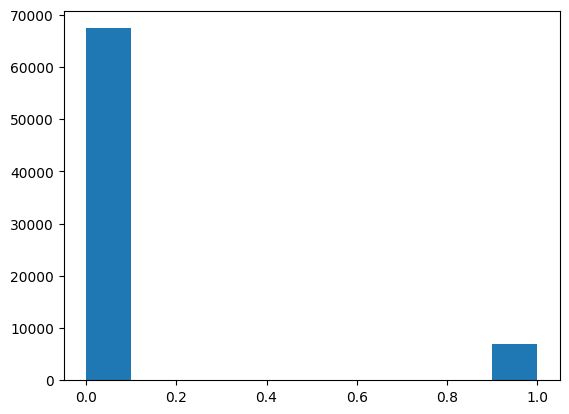

In [9]:
# Accuracy is not the right metric to use, as the classes are unbalanced
num_goals = (y_valid==1).sum()
num_no_goals = (y_valid==0).sum()
print(num_no_goals / (num_no_goals+num_goals))
plt.hist(y_valid);

# A dumb model that predicts 0 (no goals) all the time reach the same level of performance
def dumb_model(X, y):
    pred = np.zeros_like(X)
    return (y == pred).mean()


dumb_accuracy = dumb_model(X_valid, y_valid)
print(f'Dumb Accuracy on validation set = {np.around(100.*dumb_accuracy, 2)}%')

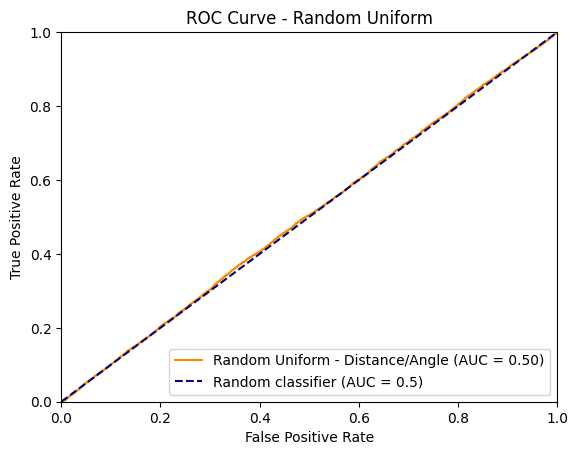

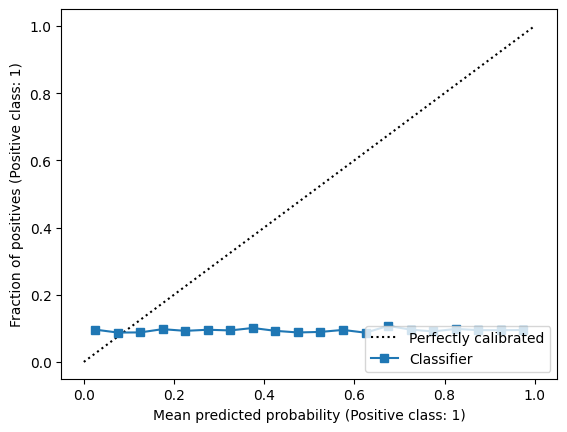

In [79]:
distance_angle_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()
X = distance_angle_data[['Shot distance', 'Shot angle']].to_numpy()
y = distance_angle_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


y_proba = np.random.uniform(low=0.0, high=1.0, size=len(y_valid))
y_proba_no_goals = y_proba
y_proba_goals = 1 - y_proba

fpr, tpr, _ = roc_curve(y_valid, y_proba_goals)
roc_auc = auc(fpr, tpr)
fpr, tpr, _ = roc_curve(y_valid.ravel(), y_proba_goals.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="Random Uniform - Distance/Angle (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Uniform")
plt.legend(loc="lower right")
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid, y_proba_goals, n_bins=20)

In [93]:
# print(y_valid)
# print(y_proba_goals)

ind = (y_proba_goals > 0.2) * (y_proba_goals <= 0.6)
print((y_valid[ind] == 1).sum())
print((y_valid[ind] == 0).sum())

print( (y_valid[ind] == 1).sum() / (y_valid[ind] == 0).sum() )

2767
26850
0.10305400372439479


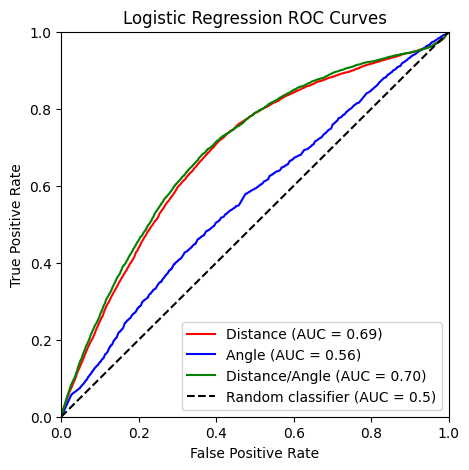

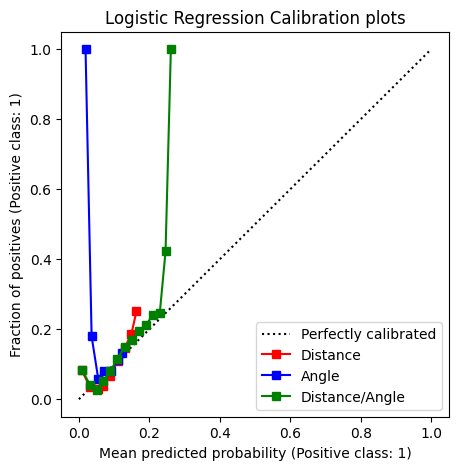

In [298]:
distance_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()
X = distance_data[['Shot distance', 'Shot angle']].to_numpy().reshape(-1, 2)
y = distance_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression - Distance only
X_distance_train, X_distance_valid = X_train[:,0].reshape(-1, 1), X_valid[:,0].reshape(-1, 1)
clf_distance = LogisticRegression(random_state=0).fit(X_distance_train, y_train)

y_proba_goals_distance = clf_distance.predict_proba(X_distance_valid)[:,1]
fpr_distance, tpr_distance, _ = roc_curve(y_valid.ravel(), y_proba_goals_distance.ravel())
roc_auc_distance = auc(fpr_distance, tpr_distance)

# Logistic Regression - Angle only
X_angle_train, X_angle_valid = X_train[:,1].reshape(-1, 1), X_valid[:,1].reshape(-1, 1)
clf_angle = LogisticRegression(random_state=0).fit(X_angle_train, y_train)

y_proba_goals_angle  = clf_angle.predict_proba(X_angle_valid)[:,1]
fpr_angle, tpr_angle, _ = roc_curve(y_valid.ravel(), y_proba_goals_angle.ravel())
roc_auc_angle = auc(fpr_angle, tpr_angle)

# Logistic Regression - Distance and Angle
X_distance_angle_train, X_distance_angle_valid = X_train, X_valid
clf_distance_angle = LogisticRegression(random_state=0).fit(X_distance_angle_train, y_train)

y_proba_goals_distance_angle  = clf_distance_angle.predict_proba(X_distance_angle_valid)[:,1]
fpr_distance_angle, tpr_distance_angle, _ = roc_curve(y_valid.ravel(), y_proba_goals_distance_angle.ravel())
roc_auc_distance_angle = auc(fpr_distance_angle, tpr_distance_angle)


plt.figure(figsize=(5, 5))
plt.plot(fpr_distance, tpr_distance, color="red", label="Distance (AUC = %0.2f)" % roc_auc_distance)
plt.plot(fpr_angle, tpr_angle, color="blue", label="Angle (AUC = %0.2f)" % roc_auc_angle)
plt.plot(fpr_distance_angle, tpr_distance_angle, color="green", label="Distance/Angle (AUC = %0.2f)" % roc_auc_distance_angle)
plt.plot([0, 1], [0, 1], color="black", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves")
plt.legend(loc="lower right")
plt.show()



fig = plt.figure(figsize=(5, 5))
gs = GridSpec(2, 2)
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
nbins = 50
calibration_displays = {
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_distance, n_bins=nbins, name='Distance', ax=ax_calibration_curve, color='red'),
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_angle, n_bins=nbins, name='Angle', ax=ax_calibration_curve, color='blue'),
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_distance_angle, n_bins=nbins, name='Distance/Angle', ax=ax_calibration_curve, color='green'),
    CalibrationDisplay.from_predictions(y_valid, np.random.uniform(low=0.0, high=1.0, size=len(y_valid)), n_bins=nbins, name='Random', ax=ax_calibration_curve, color='black')
}
ax_calibration_curve.set_title("Logistic Regression Calibration plots");


In [158]:
# Logistic Regression - Distance and Angle
X_distance_angle_train, X_distance_angle_valid = X_train, X_valid
clf_distance_angle = LogisticRegression(random_state=0).fit(X_distance_angle_train, y_train)

y_proba_goals_distance_angle  = clf_distance_angle.predict_proba(X_distance_angle_valid)[:,1]

In [159]:
y_proba_goals_distance_angle.max()

0.26112108967001973

[0.0028028425336243516, 0.03243465854884365, 0.0506907596164334, 0.05583618062268181, 0.060366207654434956, 0.0653602381050576, 0.0713172351510898, 0.07703321465924967, 0.08277404902684682, 0.08873555852892473, 0.09519297951380763, 0.10215318364811046, 0.10973322103065007, 0.11812978199369009, 0.12699223538100654, 0.13497282821204748, 0.14224669953826433, 0.1482085350237556, 0.15358068267646752, 0.17609905278562413]


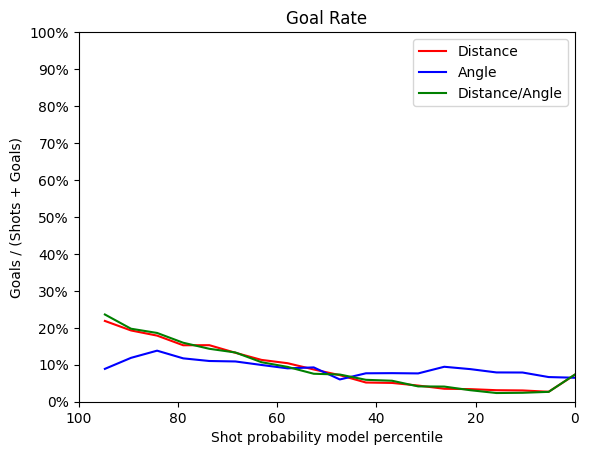

In [302]:
x = np.linspace(0, 100, 20)
percentiles_distance = [np.percentile(y_proba_goals_distance, i) for i in x]
percentiles_angle = [np.percentile(y_proba_goals_angle, i) for i in x]
percentiles_distance_angle = [np.percentile(y_proba_goals_distance_angle, i) for i in x]

print(percentiles_distance)

goals_over_total_distance = []
goals_over_total_angle = []
goals_over_total_distance_angle = []

for count_p, _ in enumerate(x[:-1]):

    ind = (y_proba_goals_distance >= percentiles_distance[count_p]) & (y_proba_goals_distance < percentiles_distance[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_distance.append(100.*ratio)

    ind = (y_proba_goals_angle >= percentiles_angle[count_p]) & (y_proba_goals_angle < percentiles_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_angle.append(100.*ratio)

    ind = (y_proba_goals_distance_angle >= percentiles_distance_angle[count_p]) & (y_proba_goals_distance_angle < percentiles_distance_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_distance_angle.append(100.*ratio)

goals_over_total_distance = np.array(goals_over_total_distance)
goals_over_total_angle = np.array(goals_over_total_angle)
goals_over_total_distance_angle = np.array(goals_over_total_distance_angle)

X = x[0:-1]
Y1 = goals_over_total_distance
Y2 = goals_over_total_angle
Y3 = goals_over_total_distance_angle


fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.plot(X, Y1, color='red', label='Distance')
plt.plot(X, Y2, color='blue', label='Angle')
plt.plot(X, Y3, color='green', label='Distance/Angle')
plt.title('Goal Rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel('Goals / (Shots + Goals)')
plt.xlim([100.0, 0.0])
plt.ylim([0.0, 100.0])
plt.yticks(range(0, 110, 10))
plt.legend(loc="upper right");
plt.show()


6990
99.9856938483548


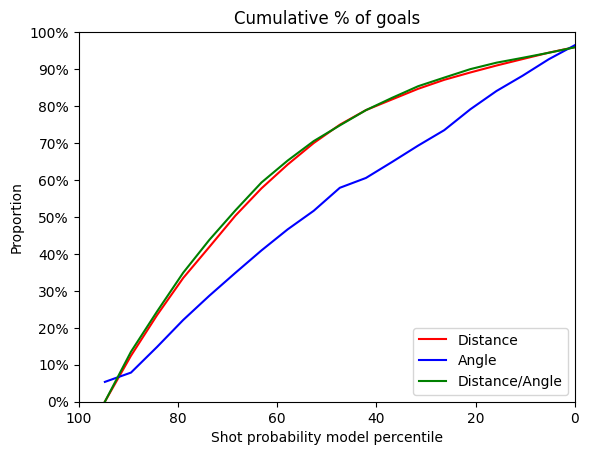

In [303]:
x = np.linspace(0, 100, 20)
percentiles_distance = [np.percentile(y_proba_goals_distance, i) for i in x]
percentiles_angle = [np.percentile(y_proba_goals_angle, i) for i in x]
percentiles_distance_angle = [np.percentile(y_proba_goals_distance_angle, i) for i in x]

goals_ratio_distance = []
goals_ratio_angle = []
goals_ratio_distance_angle = []

num_total_goals = (y_valid == 1).sum()

for count_p, _ in enumerate(x[:-1]):

    ind = (y_proba_goals_distance >= percentiles_distance[count_p]) & (y_proba_goals_distance < percentiles_distance[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_distance.append(100.*ratio)

    ind = (y_proba_goals_angle >= percentiles_angle[count_p]) & (y_proba_goals_angle < percentiles_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_angle.append(100.*ratio)

    ind = (y_proba_goals_distance_angle >= percentiles_distance_angle[count_p]) & (y_proba_goals_distance_angle < percentiles_distance_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_distance_angle.append(100.*ratio)

print((y_valid == 1).sum())
print(np.array(goals_ratio_distance).sum())
X = x[0:-1]
Y1 = 100-np.cumsum(np.array(goals_ratio_distance))
Y2 = 100-np.cumsum(np.array(goals_ratio_angle))
Y3 = 100-np.cumsum(np.array(goals_ratio_distance_angle))

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.plot(X, Y1, color='red', label='Distance')
plt.plot(X, Y2, color='blue', label='Angle')
plt.plot(X, Y3, color='green', label='Distance/Angle')
plt.title('Cumulative % of goals')
plt.xlabel('Shot probability model percentile')
plt.ylabel('Proportion')
plt.xlim([100.0, 0.0])
plt.ylim([0.0, 100.0])
plt.yticks(range(0, 110, 10));
plt.legend(loc="lower right");
plt.show()